# Proyecto 12

Prepara un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.

El modelo debe predecir la cantidad de oro extraído del mineral de oro. Dispones de los datos de extracción y purificación.

El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

Tendrás que:

Preparar los datos.
Realizar el análisis de datos.
Desarrollar un modelo y entrenarlo.

Necesitamos predecir dos valores:

La recuperación del concentrado rougher rougher.output.recovery.
La recuperación final del concentrado final.output.recovery.

## 1 Preparacion de Datos


### 1.1 Visualizacion de Datos

In [187]:
# Importar Librerias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [6]:
# Leer los datasets
data_train = pd.read_csv('gold_recovery_train.csv',index_col='date', parse_dates=True)
data_test = pd.read_csv('gold_recovery_test.csv',index_col='date', parse_dates=True)
data_full = pd.read_csv('gold_recovery_full.csv',index_col='date', parse_dates=True)

In [7]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

### 1.2 Comprobar el calculo de recuperacion 

In [9]:
# Crear una funcion para comprobar el calculo de recuperacion
def metrica_recuperacion (fila):
    numerador= fila['rougher.output.concentrate_au']* (fila['rougher.input.feed_au']- fila['rougher.output.tail_au'])
    denominador= fila['rougher.input.feed_au'] * (fila['rougher.output.concentrate_au'] - fila['rougher.output.tail_au'])
    return numerador/denominador* 100    

In [10]:
df_comprobacion_recovery = data_train.copy()

In [11]:
df_comprobacion_recovery['recuperacion_metrica']= df_comprobacion_recovery.apply(lambda fila: metrica_recuperacion(fila), axis=1)

C:\Users\Flor Borja\AppData\Local\Temp\ipykernel_5372\3781542755.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return numerador/denominador* 100
C:\Users\Flor Borja\AppData\Local\Temp\ipykernel_5372\3781542755.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return numerador/denominador* 100


In [12]:
diferencia_real_vs_metrica = (df_comprobacion_recovery['recuperacion_metrica'] - df_comprobacion_recovery['rougher.output.recovery'])

In [13]:
diferencia_real_vs_metrica.abs().mean()

9.303415616264301e-15

#### Observacion 
El calculo de recuperacion es correcto al aplicarlo en el conjunto de entrenamiento y compararlo con los datos de la caracteristica rougher.output.recovery 

### 1.3 Analizar las caracteristicas no disponibles en el conjunto de prueba

In [16]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

In [17]:
# Rellenar los datos con el metodo ffill en los dataset del conjunto de entremaiento y prueba
data_train = data_train.ffill()
data_test = data_test.ffill()

In [18]:
# Calcular la longuitud de las columnas para visualizae cuantas faltan en el conjunto de prueba 
len(data_train.columns)

86

In [19]:
len(data_test.columns)

52

In [20]:
missed_test_columns = set(list(data_train.columns.values)) - set(list(data_test.columns.values))

In [21]:
missed_test_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Observacion 
En el conjunto de prueba no se observan las caracteristicas output propias del proceso de flotacion del oro y el tipo de caracteristicas son valores flotantes.

### 1.4 Preproceamiento de Datos

In [24]:
# En el dataset que tienen los datos completos se va realizar el preprocesamiento de Datos 
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

In [25]:
# Rellenar los valores con el metodo ffill
data_full = data_full.ffill()

In [26]:
data_full.isna().sum().sort_values(ascending = False)

final.output.concentrate_ag                   0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_e_air               0
                                             ..
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_b_level      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

## 2. Analisis de Datos

### 2.1 Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

In [29]:
# Establecer el proceso de purificacion
procesos =[ 
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}'
]

In [30]:
# Crear una funcion para graficar la concentracion
def grafico_concentracion(material):
    pasos = [paso.format(material) for paso in procesos]
    for paso in pasos:
        data_full[paso].hist(alpha=0.5, bins=20)
        plt.legend(pasos)  

Text(0.5, 1.0, 'Cambio de concentracion en el oro')

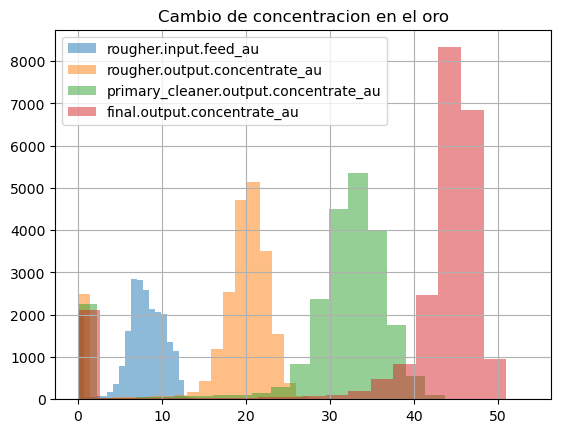

In [31]:
grafico_concentracion('au')
plt.title('Cambio de concentracion en el oro')

Text(0.5, 1.0, 'Cambio de concentracion en la plata')

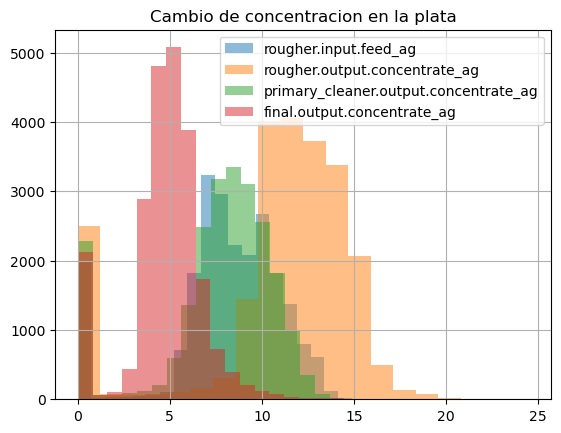

In [32]:
grafico_concentracion('ag')
plt.title('Cambio de concentracion en la plata')

Text(0.5, 1.0, 'Cambio de concentracion en el plomo')

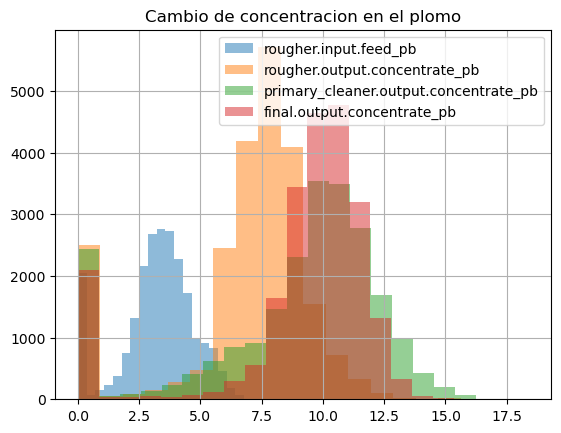

In [33]:
grafico_concentracion('pb')
plt.title('Cambio de concentracion en el plomo')

### 2.2 Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. 

In [35]:
# Crear una funcion que filtre el párametro feed_sive que es el tamaño de las particulas de alimentaicon de cada conjunto.
def filtrar_columnas_feed_size(dataset, clave='feed_size'):
    """
    Filtra las columnas que contienen 'feed_size' en el nombre del dataset.

    Args:
        dataset (DataFrame): Dataset a filtrar.
        clave (str): Palabra clave para buscar en los nombres de las columnas.

    Returns:
        DataFrame: Un DataFrame con solo las columnas que contienen la clave.
    """
    columnas = [col for col in dataset.columns if clave in col]
    if not columnas:
        raise ValueError(f"No se encontraron columnas que contengan '{clave}' en el dataset.")
    return dataset[columnas]

# Craer una funcion para comparar las distribucion de cada conjunto 
def comparar_distribuciones_feed_size(conjunto_entrenamiento, conjunto_prueba, clave='feed_size'):
    """
    Compara las distribuciones de las columnas filtradas que contienen 'feed_size' 
    entre los datasets de entrenamiento y prueba.

    Args:
        conjunto_entrenamiento (DataFrame): Dataset de entrenamiento.
        conjunto_prueba (DataFrame): Dataset de prueba.
        clave (str): Palabra clave para buscar columnas (por defecto 'feed_size').
    """
    # Filtrar las columnas que contienen 'feed_size'
    entrenamiento_filtrado = filtrar_columnas_feed_size(conjunto_entrenamiento, clave)
    prueba_filtrada = filtrar_columnas_feed_size(conjunto_prueba, clave)
    
    # Verificar que los datasets tengan las mismas columnas para comparar
    columnas_comunes = set(entrenamiento_filtrado.columns).intersection(set(prueba_filtrada.columns))
    if not columnas_comunes:
        raise ValueError("No hay columnas comunes con 'feed_size' entre los datasets de entrenamiento y prueba.")
    
    # Comparar las distribuciones de las columnas comunes
    for columna in columnas_comunes:
        plt.figure(figsize=(10, 6))
        plt.hist(entrenamiento_filtrado[columna], bins=20, alpha=0.6, label='Conjunto de Entrenamiento', color='blue')
        plt.hist(prueba_filtrada[columna], bins=20, alpha=0.6, label='Conjunto de Prueba', color='orange')
        
        # Configuración del gráfico
        plt.title(f'Comparación de Distribuciones: {columna}')
        plt.xlabel('Valores')
        plt.ylabel('Frecuencia')
        plt.legend(loc='upper right')
        plt.show()

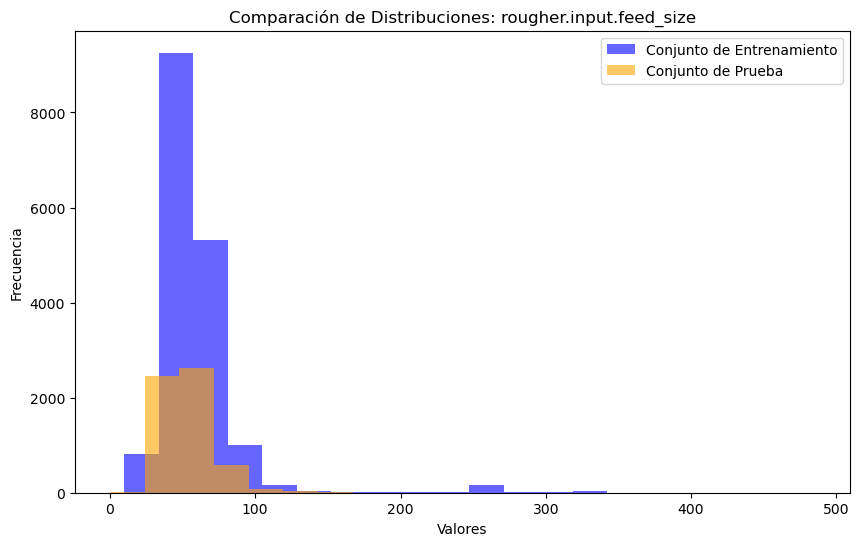

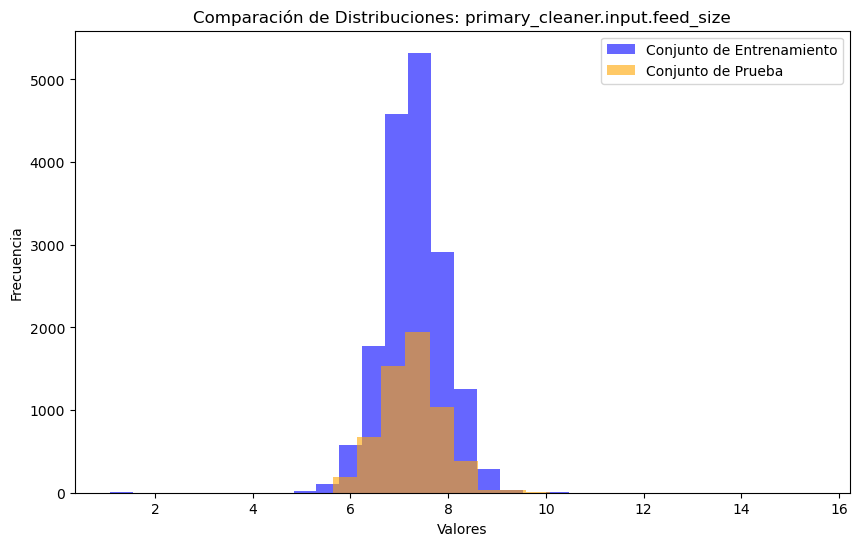

In [36]:
conjunto_entrenamiento = pd.DataFrame(data_train)
conjunto_prueba = pd.DataFrame(data_test)

# Usar la función
comparar_distribuciones_feed_size(conjunto_entrenamiento, conjunto_prueba)

### Observacion
Las distibuciones del tamaño de las particulas de alimentacion en el conjunto de entrenamiento y de prueba no varian significativamente

### 2.3  Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? 

In [39]:
def crear_histograma_concentraciones(dataset, columnas_etapas):
    """
    Crea un histograma de las concentraciones totales en diferentes etapas.

    Args:
        dataset (DataFrame): Dataset que contiene las columnas con las etapas.
        columnas_etapas (list): Lista de nombres de columnas que representan las etapas.
    """
    # Calcular la suma total de las concentraciones para todas las etapas
    dataset['concentracion_total'] = dataset[columnas_etapas].sum(axis=1)
    
    # Crear el histograma
    plt.figure(figsize=(10, 6))
    plt.hist(dataset['concentracion_total'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    
    # Configuración del gráfico
    plt.title('Distribución de las Concentraciones Totales')
    plt.xlabel('Concentración Total')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

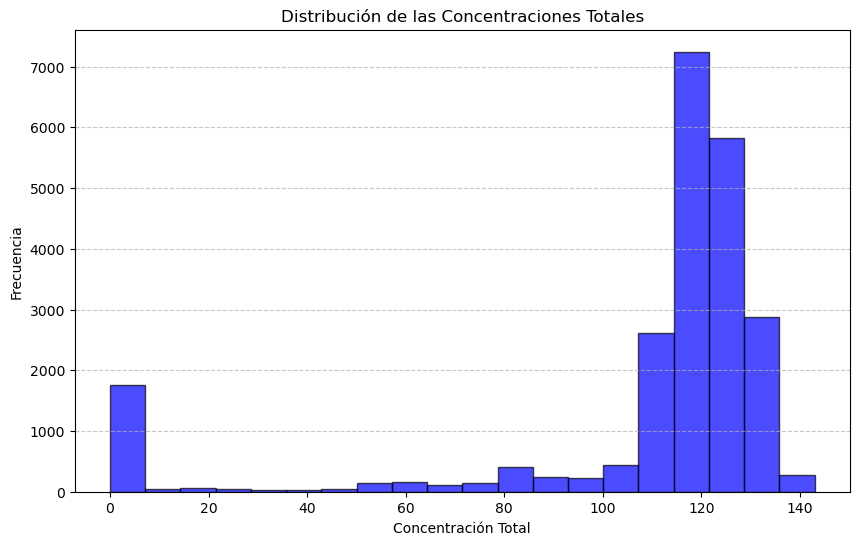

In [40]:
dataset = pd.DataFrame(data_full)

# Columnas de las etapas
columnas_etapas = [ 'rougher.input.feed_au','rougher.input.feed_ag', 'rougher.input.feed_pb',
    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag','rougher.output.concentrate_pb',
    'final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb'
                  ]

# Crear el histograma
crear_histograma_concentraciones(dataset, columnas_etapas)

#### Observacion
Hay valores anormales en la distribucion de la concentracion total de todas la sustancias en cada etapa 

## 3. Contruccion del Modelo

### 3.1 Escribe una funcion para calcular el valor final de sMAPE

In [154]:
# Funcion para calcular el valor final de sMAPE
def calcular_sMAPE(valores_reales, valores_predichos):
    valores_reales = np.array(valores_reales)
    valores_predichos = np.array(valores_predichos)
    
    # Crear una máscara para ignorar pares donde ambos valores son 0
    mask = ~(valores_reales == 0) & ~(valores_predichos == 0)
    
    # Aplicar la máscara para filtrar los valores válidos
    valores_reales_filtrados = valores_reales[mask]
    valores_predichos_filtrados = valores_predichos[mask]
    
    # Calcular el sMAPE solo con los valores filtrados
    numerador = np.abs(valores_reales_filtrados - valores_predichos_filtrados)
    denominador = (np.abs(valores_reales_filtrados) + np.abs(valores_predichos_filtrados)) / 2
    smape = np.mean(numerador / denominador) * 100
    
    return smape

def calcular_metrica_final(valores_reales_rougher, valores_predichos_rougher, 
                           valores_reales_final, valores_predichos_final):
    
    smape_rougher = calcular_sMAPE(valores_reales_rougher, valores_predichos_rougher)
    smape_final = calcular_sMAPE(valores_reales_final, valores_predichos_final)
    
    # Calcular la métrica final ponderada
    metrica_final = 0.25 * smape_rougher + 0.75 * smape_final
    
    return metrica_final

### 3.2 Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba.

#### 3.2.1 Escoger el dataset para la evalucion del modelo y realizar el preprocesamiento 

In [48]:
# En este caso para entrenar el modelo se escoeger el dataset fuente que contiene todos los datos de entrenamiento y prueba y se va rellenar los datos con ffill.
data_clean = data_full.ffill()

In [49]:
data_clean.isnull().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

In [50]:
data_clean.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,...,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000
mean,4.768013,9.071366,8.537502,39.891718,66.475263,8.900622,2.471149,9.434396,2.819885,131.338303,...,18.105943,-501.274111,14.302334,-477.753153,14.831127,-504.279270,11.588761,-501.510723,17.904473,-520.266675
std,2.042594,3.260960,3.858203,13.540157,13.042781,3.544045,1.201069,4.145832,1.269214,58.477466,...,6.672497,82.631294,5.710034,95.648618,6.417280,74.648011,5.780520,80.663516,6.717178,76.976308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.011471,8.737809,7.036629,42.353890,62.258453,7.669323,1.780344,8.050901,2.297002,101.198976,...,14.046697,-500.919584,10.141535,-500.319422,10.938055,-500.641708,8.031211,-500.171370,13.031799,-501.000058
50%,4.949959,9.910363,8.858385,44.639019,67.981407,9.477554,2.643964,10.174399,2.910336,137.084713,...,18.004609,-499.924952,14.945528,-499.616792,14.615849,-499.868380,10.987789,-499.953415,18.002995,-500.098653
75%,5.857985,10.927188,10.667178,46.106662,72.941119,11.084153,3.282285,11.840024,3.552452,170.993920,...,22.996115,-498.369203,17.962227,-400.229299,18.014080,-498.503626,13.999903,-499.499414,23.007616,-499.527882
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [51]:
# Eliminar las caracteristicas que no se mencionan en el proceso tecnologico del oro y definir los dos objetivos que se desea predecir tanto como el concentrado rougher y el concentrado final.
caracteristicas_1 = data_clean[['rougher.input.feed_au','rougher.output.tail_au','rougher.output.concentrate_au']]
caracteristicas_2 = data_clean[['primary_cleaner.output.tail_au','primary_cleaner.output.concentrate_au','secondary_cleaner.output.tail_au','final.output.tail_au','final.output.concentrate_au']]
objetivo_1 = data_clean['rougher.output.recovery']
objetivo_2 = data_clean['final.output.recovery']

#### 3.2.2 Entrenar un modelo de regresion lineal 

In [125]:
def entrenar_modelo(caracteristicas, objetivo, test_size=0.2, random_state=42):
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(caracteristicas, objetivo, test_size=test_size, random_state=random_state)

    # Escalar las características
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Entrenar el modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Predicciones y cálculo de error
    prediccion = modelo.predict(X_test)
    rmse = root_mean_squared_error(y_test, prediccion)
    print('RMSE', rmse)
    resultado= pd.DataFrame(dict(prediccion_valores = prediccion, valor_real = y_test))
    smape= calcular_sMAPE(resultado['valor_real'], resultado['prediccion_valores'])
    print('SMAPE', smape)
   
    return resultado

In [127]:
 entrenar_modelo(caracteristicas_1, objetivo_1, test_size=0.2, random_state=42)

RMSE 14.359620648760739
SMAPE 14.1332454216192


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,80.326884,89.520904
2017-06-03 13:59:59,84.560423,80.994927
2017-03-03 09:59:59,86.542025,94.980094
2016-08-30 10:59:59,83.367039,76.388361
2018-02-25 13:59:59,88.449853,97.177847
...,...,...
2017-07-03 21:59:59,82.844214,77.128221
2016-03-31 14:00:00,60.035053,78.998992
2017-08-08 08:59:59,86.834874,87.418343


In [143]:
entrenar_modelo(caracteristicas_2, objetivo_2, test_size=0.2, random_state=42)

RMSE 11.50756975067642
SMAPE 12.946680455760573


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,65.130859,71.333042
2017-06-03 13:59:59,41.064327,42.125635
2017-03-03 09:59:59,79.776662,100.000000
2016-08-30 10:59:59,65.033823,60.699442
2018-02-25 13:59:59,72.584980,73.870714
...,...,...
2017-07-03 21:59:59,67.976519,63.525919
2016-03-31 14:00:00,65.790961,39.381992
2017-08-08 08:59:59,71.217142,69.510739


#### 2.2.3 Entrenar un modelo de Arbol de Regresion

In [204]:
def probar_arbol_regresion(caracteristicas, objetivo, test_size=0.2, random_state=42, max_depth=None):
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(caracteristicas, objetivo, test_size=test_size, random_state=random_state)
    
    # Crear y entrenar el árbol de regresión
    modelo = DecisionTreeRegressor(random_state=random_state, max_depth=max_depth)
    modelo.fit(X_train, y_train)
    
    # Realizar predicciones
    prediccion = modelo.predict(X_test)
    
    # Calcular el RMSE
    rmse = root_mean_squared_error(y_test, prediccion)
    print(f"Error (RMSE): {rmse}")
    resultado_arbol= pd.DataFrame(dict(prediccion_valores = prediccion, valor_real = y_test))
    smape= calcular_sMAPE(resultado_arbol['valor_real'], resultado_arbol['prediccion_valores'])
    print('SMAPE', smape)

    return resultado_arbol

In [206]:
probar_arbol_regresion(caracteristicas_1, objetivo_1, test_size=0.2, random_state=42, max_depth=None)

Error (RMSE): 6.739397271863331
SMAPE 1.2326348514400272


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,89.221717,89.520904
2017-06-03 13:59:59,79.872973,80.994927
2017-03-03 09:59:59,94.435087,94.980094
2016-08-30 10:59:59,75.762794,76.388361
2018-02-25 13:59:59,97.502915,97.177847
...,...,...
2017-07-03 21:59:59,76.545722,77.128221
2016-03-31 14:00:00,78.998992,78.998992
2017-08-08 08:59:59,87.412476,87.418343


In [160]:
probar_arbol_regresion(caracteristicas_2, objetivo_2, test_size=0.2, random_state=42, max_depth=None)

Error (RMSE): 11.13797578054157
SMAPE 10.701650324239557


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,71.114952,71.333042
2017-06-03 13:59:59,33.634310,42.125635
2017-03-03 09:59:59,100.000000,100.000000
2016-08-30 10:59:59,56.269644,60.699442
2018-02-25 13:59:59,67.566607,73.870714
...,...,...
2017-07-03 21:59:59,82.184884,63.525919
2016-03-31 14:00:00,57.999929,39.381992
2017-08-08 08:59:59,71.771975,69.510739


#### 3.2.4 Entrenar un Bosque de Regresion 

In [180]:
def probar_bosque_regresion(caracteristicas, objetivo, test_size=0.2, random_state=42, n_estimators=100, max_depth=None):
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(caracteristicas, objetivo, test_size=test_size, random_state=random_state)
    
    # Crear y entrenar el Bosque de Regresión
    modelo = RandomForestRegressor(random_state=random_state, n_estimators=n_estimators, max_depth=max_depth)
    modelo.fit(X_train, y_train)
    
    # Realizar predicciones
    prediccion = modelo.predict(X_test)
    
    # Calcular el RMSE
    rmse = root_mean_squared_error(y_test, prediccion)
    print(f"Error (RMSE): {rmse}")
    resultado_bosque= pd.DataFrame(dict(prediccion_valores = prediccion, valor_real = y_test))
    smape= calcular_sMAPE(resultado_bosque['valor_real'], resultado_bosque['prediccion_valores'])
    print('SMAPE', smape)
    
    return resultado_bosque

In [182]:
probar_bosque_regresion(caracteristicas_1, objetivo_1, test_size=0.2, random_state=42, n_estimators=100, max_depth=None)

Error (RMSE): 5.561551736728578
SMAPE 1.0643006257690324


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,86.739974,89.520904
2017-06-03 13:59:59,80.862352,80.994927
2017-03-03 09:59:59,94.899391,94.980094
2016-08-30 10:59:59,65.561570,76.388361
2018-02-25 13:59:59,97.177205,97.177847
...,...,...
2017-07-03 21:59:59,77.149197,77.128221
2016-03-31 14:00:00,78.998992,78.998992
2017-08-08 08:59:59,87.457749,87.418343


In [166]:
probar_bosque_regresion(caracteristicas_2, objetivo_2, test_size=0.2, random_state=42, n_estimators=100, max_depth=None)

Error (RMSE): 8.341387049022185
SMAPE 8.070645689632306


,prediccion_valores,valor_real
date,,
2017-10-31 12:59:59,71.988649,71.333042
2017-06-03 13:59:59,39.295330,42.125635
2017-03-03 09:59:59,99.697094,100.000000
2016-08-30 10:59:59,64.196940,60.699442
2018-02-25 13:59:59,75.301078,73.870714
...,...,...
2017-07-03 21:59:59,65.512734,63.525919
2016-03-31 14:00:00,58.030647,39.381992
2017-08-08 08:59:59,71.001730,69.510739


#### 3.3.4 Realizar la validacion cruzada

In [193]:
# Modelos a evaluar
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Árbol de Regresión": DecisionTreeRegressor(random_state=42),
    "Bosque de Regresión": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Convertir la función en un scorer compatible con scikit-learn
smape_scorer = make_scorer(calcular_sMAPE)
# Realizar evaluación cruzada para cada modelo 
resultados_smape = {}
for nombre, modelo in modelos.items():
    puntuaciones = cross_val_score(modelo, caracteristicas_1, objetivo_1, cv=5, scoring=smape_scorer)
    resultados_smape[nombre] = np.mean(puntuaciones)  # Promedio de sMAPE

# Imprimir los resultados de sMAPE
for modelo, smape in resultados_smape.items():
    print(f"{modelo}: sMAPE promedio = {smape:.2f}%")

Regresión Lineal: sMAPE promedio = 10.36%
Árbol de Regresión: sMAPE promedio = 4.24%
Bosque de Regresión: sMAPE promedio = 5.78%


In [195]:
# Realizar evaluación cruzada para cada modelo 
resultados_smape = {}
for nombre, modelo in modelos.items():
    puntuaciones = cross_val_score(modelo, caracteristicas_2, objetivo_2, cv=5, scoring=smape_scorer)
    resultados_smape[nombre] = np.mean(puntuaciones)  # Promedio de sMAPE

# Imprimir los resultados de sMAPE
for modelo, smape in resultados_smape.items():
    print(f"{modelo}: sMAPE promedio = {smape:.2f}%")

Regresión Lineal: sMAPE promedio = 11.77%
Árbol de Regresión: sMAPE promedio = 14.52%
Bosque de Regresión: sMAPE promedio = 11.74%


#### Observacion 
Para el concentrado rougher el mejor modelo es el Arbol de Regresion y para el concentrado final el mejor modelo es el Bosque de Regresion  

In [237]:
#Modelo para el concentrado rougher
#Dividir los datos en entrenamiento y prueba 
X_train, X_test, y_train, y_test = train_test_split(caracteristicas_1, objetivo_1, test_size=0.2, random_state=42)

# Crear y entrenar el árbol de regresión
modelo = DecisionTreeRegressor(random_state=42, max_depth=None)
modelo.fit(X_train, y_train)
    
# Realizar predicciones
prediccion = modelo.predict(X_test)
    
# Calcular el resultado
resultado_arbol= pd.DataFrame(dict(prediccion_valores = prediccion, valor_real = y_test))
print(resultado_arbol['prediccion_valores'].sum())
smape= calcular_sMAPE(resultado_arbol['valor_real'], resultado_arbol['prediccion_valores'])
print('SMAPE', smape)

371218.8391230931
SMAPE 1.2326348514400272


In [239]:
#Modelo para el concentrado final 
#Dividir los datos de entrenamiento y prueba 
X_train, X_test, y_train, y_test = train_test_split(caracteristicas_2, objetivo_2, test_size=0.2, random_state=42)
    
# Crear y entrenar el Bosque de Regresión
modelo = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None)
modelo.fit(X_train, y_train)
    
# Realizar predicciones
prediccion = modelo.predict(X_test)
    
# Calcular el resultado
resultado_bosque= pd.DataFrame(dict(prediccion_valores = prediccion, valor_real = y_test))
print(resultado_bosque['prediccion_valores'].sum())
smape= calcular_sMAPE(resultado_bosque['valor_real'], resultado_bosque['prediccion_valores'])
print('SMAPE', smape)

301887.21148359816
SMAPE 8.070645689632306


In [224]:
# Calcular metrica Final con los valores del bosque de regresion y el arbol de regresion

valores_reales_rougher = resultado_arbol['valor_real']
valores_predichos_rougher = resultado_arbol['prediccion_valores']

valores_reales_final = resultado_bosque['valor_real']
valores_predichos_final = resultado_bosque['prediccion_valores']

# Calcular la métrica final
metrica_final = calcular_metrica_final(valores_reales_rougher, valores_predichos_rougher, 
                                       valores_reales_final, valores_predichos_final)

print(f"Métrica final: {metrica_final:.2f}")


Métrica final: 6.36


## Conclusion Final 
Al entrenar varios modelos se pudo evidenciar que el concentrado rougher y el concentrado final en sus predicciones se calculan mas eficientemente en diferente modelos y al final se entreno estos modelos que eran mas eficientes para cada uno y calculo la metrica final la cual es 6.36 porciento de comparacion entre los valores reales y las prediciones. La cantiadad de oro extraido final es menor al del concentrado rougher y esto debido a que segun el proceso tecnologico explicado luego de la purificacion va perdiendo concentracion.

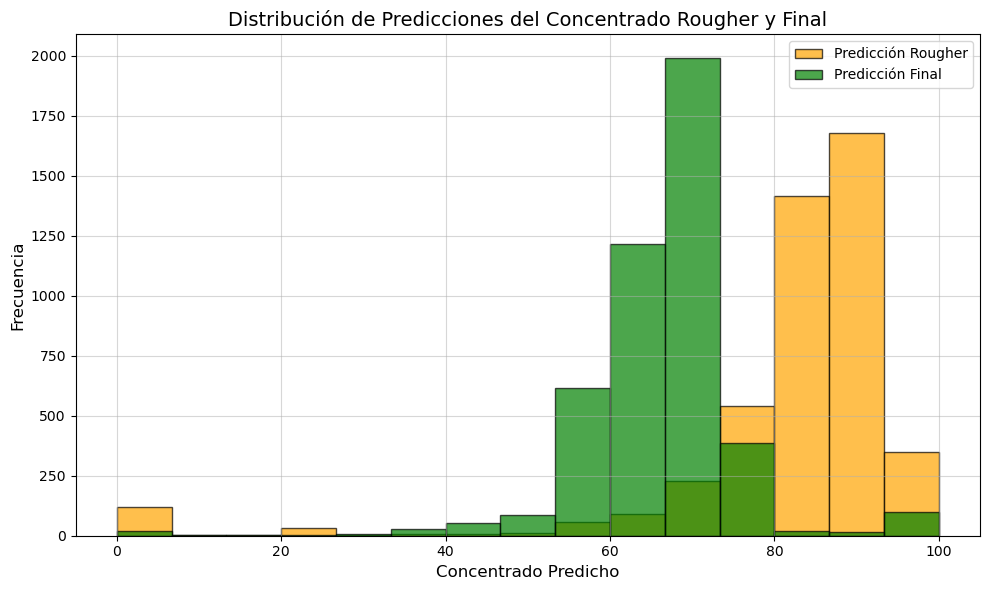

In [246]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(10, 6))

# Histograma para las predicciones rougher
plt.hist(valores_predichos_rougher, bins=15, alpha=0.7, label="Predicción Rougher", color='orange', edgecolor='black')

# Histograma para las predicciones finales
plt.hist(valores_predichos_final, bins=15, alpha=0.7, label="Predicción Final", color='green', edgecolor='black')

# Personalización del gráfico
plt.title("Distribución de Predicciones del Concentrado Rougher y Final", fontsize=14)
plt.xlabel("Concentrado Predicho", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Mostrar el histograma
plt.tight_layout()
plt.show()